In [65]:
from utils import *
from tqdm import tqdm
import argparse
import scipy
import multiprocessing as mp

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [129]:
parser = argparse.ArgumentParser(description='Training GCN on Cora/CiteSeer/PubMed/Reddit Datasets')

'''
    Dataset arguments
'''
parser.add_argument('--dataset', type=str, default='cora',
                    help='Dataset name: cora/citeseer/pubmed/Reddit')
parser.add_argument('--nhid', type=int, default=256,
                    help='Hidden state dimension')
parser.add_argument('--epoch_num', type=int, default= 100,
                    help='Number of Epoch')
parser.add_argument('--pool_num', type=int, default= 10,
                    help='Number of Pool')
parser.add_argument('--batch_num', type=int, default= 10,
                    help='Maximum Batch Number')
parser.add_argument('--batch_size', type=int, default=512,
                    help='size of output node in a batch')
parser.add_argument('--n_layers', type=int, default=5,
                    help='Number of GCN layers')
parser.add_argument('--n_iters', type=int, default=1,
                    help='Number of iteration to run on a batch')
parser.add_argument('--n_stops', type=int, default=200,
                    help='Stop after number of batches that f1 dont increase')
parser.add_argument('--samp_num', type=int, default=64,
                    help='Number of sampled nodes per layer')
parser.add_argument('--sample_method', type=str, default='ladies',
                    help='Sampled Algorithms: ladies/fastgcn/full')
parser.add_argument('--cuda', type=int, default=-1,
                    help='Avaiable GPU ID')



args = parser.parse_args("")

In [130]:
class GraphConvolution(nn.Module):
    def __init__(self, n_in, n_out, bias=True):
        super(GraphConvolution, self).__init__()
        self.n_in  = n_in
        self.n_out = n_out
        self.linear = nn.Linear(n_in,  n_out)
    def forward(self, x, adj):
        out = self.linear(x)
        return F.elu(torch.spmm(adj, out))


class GCN(nn.Module):
    def __init__(self, nfeat, nhid, layers, dropout):
        super(GCN, self).__init__()
        self.layers = layers
        self.nhid = nhid
        self.gcs = nn.ModuleList()
        self.gcs.append(GraphConvolution(nfeat,  nhid))
        self.dropout = nn.Dropout(dropout)
        for i in range(layers-1):
            self.gcs.append(GraphConvolution(nhid,  nhid))
    def forward(self, x, adjs):
        '''
            The difference here with the original GCN implementation is that
            we will receive different adjacency matrix for different layer.
        '''
        for idx in range(len(self.gcs)):
            x = self.dropout(self.gcs[idx](x, adjs[idx]))
        return x

class SuGCN(nn.Module):
    def __init__(self, encoder, num_classes, dropout, inp):
        super(SuGCN, self).__init__()
        self.encoder = encoder
        self.dropout = nn.Dropout(dropout)
        self.linear  = nn.Linear(self.encoder.nhid, num_classes)
    def forward(self, feat, adjs):
        x = self.encoder(feat, adjs)
        x = self.dropout(x)
        x = self.linear(x)
        return x

In [131]:
def fastgcn_sampler(seed, batch_nodes, samp_num_list, num_nodes, lap_matrix, depth):
    '''
        FastGCN_Sampler: Sample a fixed number of nodes per layer. The sampling probability (importance)
                         is pre-computed based on the global degree (lap_matrix)
    '''
    np.random.seed(seed)
    previous_nodes = batch_nodes
    adjs  = []
    #     pre-compute the sampling probability (importance) based on the global degree (lap_matrix)
    pi = np.array(np.sum(lap_matrix.multiply(lap_matrix), axis=0))[0]
    p = pi / np.sum(pi)
    '''
        Sample nodes from top to bottom, based on the pre-computed probability. Then reconstruct the adjacency matrix.
    '''
    for d in range(depth):
        #     row-select the lap_matrix (U) by previously sampled nodes
        U = lap_matrix[previous_nodes , :]
        #     sample the next layer's nodes based on the pre-computed probability (p).
        s_num = np.min([np.sum(p > 0), samp_num_list[d]])
        after_nodes = np.random.choice(num_nodes, s_num, p = p, replace = False)
        #     col-select the lap_matrix (U), and then devided by the sampled probability for 
        #     unbiased-sampling. Finally, conduct row-normalization to avoid value explosion.         
        adj = row_norm(U[: , after_nodes].multiply(1/p[after_nodes]))
        #     Turn the sampled adjacency matrix into a sparse matrix. If implemented by PyG
        #     This sparse matrix can also provide index and value.
        adjs += [sparse_mx_to_torch_sparse_tensor(row_normalize(adj))]
        #     Turn the sampled nodes as previous_nodes, recursively conduct sampling.
        previous_nodes = after_nodes
    #     Reverse the sampled probability from bottom to top. Only require input how the lastly sampled nodes.
    adjs.reverse()
    return adjs, previous_nodes, batch_nodes

def ladies_sampler(seed, batch_nodes, samp_num_list, num_nodes, lap_matrix, depth):
    '''
        LADIES_Sampler: Sample a fixed number of nodes per layer. The sampling probability (importance)
                         is computed adaptively according to the nodes sampled in the upper layer.
    '''
    np.random.seed(seed)
    previous_nodes = batch_nodes
    adjs  = []
    '''
        Sample nodes from top to bottom, based on the probability computed adaptively (layer-dependent).
    '''
    for d in range(depth):
        #     row-select the lap_matrix (U) by previously sampled nodes
        U = lap_matrix[previous_nodes , :]
        #     Only use the upper layer's neighborhood to calculate the probability.
        pi = np.array(np.sum(U.multiply(U), axis=0))[0]
        p = pi / np.sum(pi)
        s_num = np.min([np.sum(p > 0), samp_num_list[d]])
        #     sample the next layer's nodes based on the adaptively probability (p).
        after_nodes = np.random.choice(num_nodes, s_num, p = p, replace = False)
        #     Add output nodes for self-loop
        after_nodes = np.unique(np.concatenate((after_nodes, batch_nodes)))
        #     col-select the lap_matrix (U), and then devided by the sampled probability for 
        #     unbiased-sampling. Finally, conduct row-normalization to avoid value explosion.      
        adj = U[: , after_nodes].multiply(1/p[after_nodes])
        adjs += [sparse_mx_to_torch_sparse_tensor(row_normalize(adj))]
        #     Turn the sampled nodes as previous_nodes, recursively conduct sampling.
        previous_nodes = after_nodes
    #     Reverse the sampled probability from bottom to top. Only require input how the lastly sampled nodes.
    adjs.reverse()
    return adjs, previous_nodes, batch_nodes

def default_sampler(seed, batch_nodes, samp_num_list, num_nodes, lap_matrix, depth):
    mx = sparse_mx_to_torch_sparse_tensor(lap_matrix)
    return [mx for i in range(depth)], np.arange(num_nodes), batch_nodes



In [132]:
def prepare_data(pool, sampler, process_ids, train_nodes, valid_nodes, samp_num_list, num_nodes, lap_matrix, depth):
    jobs = []
    for _ in process_ids:
        idx = torch.randperm(len(train_nodes))[:args.batch_size]
        batch_nodes = train_nodes[idx]
        p = pool.apply_async(sampler, args=(np.random.randint(2**32 - 1), batch_nodes, samp_num_list, num_nodes, lap_matrix, depth))
        jobs.append(p)
    idx = torch.randperm(len(valid_nodes))[:args.batch_size]
    batch_nodes = valid_nodes[idx]
    p = pool.apply_async(sampler, args=(np.random.randint(2**32 - 1), batch_nodes, samp_num_list * 20, num_nodes, lap_matrix, depth))
    jobs.append(p)
    return jobs

def package_mxl(mxl, device):
    return [torch.sparse.FloatTensor(mx[0], mx[1], mx[2]).to(device) for mx in mxl]


In [133]:
if args.cuda != -1:
    device = torch.device("cuda:" + str(args.cuda))
else:
    device = torch.device("cpu")

In [135]:
print(args.dataset, args.sample_method)

cora ladies


In [136]:
edges, labels, feat_data, num_classes, train_nodes, valid_nodes, test_nodes = load_data(args.dataset)

In [137]:
## Dataset: Cora
# nodes = 2708
# edges = 10858
# feature set : 2708, 1433
# num_classes : 7
# dataset split :
#   train: 140
#   val: 500
#   test: 1000

## Dataset: citeseer
# nodes = 3327
# edges = 9464
# feature set : 3327, 3703
# num_classes : 6
# dataset split :
#   train: 120
#   val: 500
#   test: 1000

## Dataset: PubMed
# nodes = 19717
# edges = 88676
# feature set : 19717, 500
# num_classes : 3
# dataset split :
#   train: 60
#   val: 500
#   test: 1000

In [138]:
adj_matrix = get_adj(edges, feat_data.shape[0])

In [139]:
adj_matrix.shape

(2708, 2708)

In [140]:
lap_matrix = row_normalize(adj_matrix + sp.eye(adj_matrix.shape[0]))
if type(feat_data) == scipy.sparse.lil.lil_matrix:
    feat_data = torch.FloatTensor(feat_data.todense()).to(device)
else:
    feat_data = torch.FloatTensor(feat_data).to(device)
labels = torch.LongTensor(labels).to(device)

In [142]:
if args.sample_method == 'ladies':
    sampler = ladies_sampler
elif args.sample_method == 'fastgcn':
    sampler = fastgcn_sampler
elif args.sample_method == 'full':
    sampler = default_sampler

In [143]:
process_ids = np.arange(args.batch_num)
samp_num_list = np.array([args.samp_num, args.samp_num, args.samp_num, args.samp_num, args.samp_num])

pool = mp.Pool(args.pool_num)
jobs = prepare_data(pool, sampler, process_ids, train_nodes, valid_nodes, samp_num_list, len(feat_data), lap_matrix, args.n_layers)


In [151]:
all_res = {}
for oiter in range(5):
    encoder = GCN(nfeat = feat_data.shape[1], nhid=args.nhid, layers=args.n_layers, dropout = 0.2).to(device)
    susage  = SuGCN(encoder = encoder, num_classes=num_classes, dropout=0.5, inp = feat_data.shape[1])
    susage.to(device)

    optimizer = optim.Adam(filter(lambda p : p.requires_grad, susage.parameters()))
    best_val = 0
    best_tst = -1
    cnt = 0
    times = []
    all_res[oiter] = {'train': [], 'test': []}
    print('-' * 10)
    for epoch in np.arange(args.epoch_num):
        susage.train()
        train_losses = []
        train_data = [job.get() for job in jobs[:-1]]
        valid_data = jobs[-1].get()
        pool.close()
        pool.join()
        pool = mp.Pool(args.pool_num)
        '''
            Use CPU-GPU cooperation to reduce the overhead for sampling. (conduct sampling while training)
        '''
        jobs = prepare_data(pool, sampler, process_ids, train_nodes, valid_nodes, samp_num_list, len(feat_data), lap_matrix, args.n_layers)
        for _iter in range(args.n_iters):
            for adjs, input_nodes, output_nodes in train_data:    
                adjs = package_mxl(adjs, device)
                optimizer.zero_grad()
                t1 = time.time()
                susage.train()
                output = susage.forward(feat_data[input_nodes], adjs)
                if args.sample_method == 'full':
                    output = output[output_nodes]
                loss_train = F.cross_entropy(output, labels[output_nodes])
                loss_train.backward()
                torch.nn.utils.clip_grad_norm_(susage.parameters(), 0.2)
                optimizer.step()
                times += [time.time() - t1]
                train_losses += [loss_train.detach().tolist()]
                del loss_train
        susage.eval()
        adjs, input_nodes, output_nodes = valid_data
        adjs = package_mxl(adjs, device)
        output = susage.forward(feat_data[input_nodes], adjs)
        if args.sample_method == 'full':
            output = output[output_nodes]
        loss_valid = F.cross_entropy(output, labels[output_nodes]).detach().tolist()
        valid_f1 = f1_score(output.argmax(dim=1).cpu(), labels[output_nodes].cpu(), average='micro')
        print(("Epoch: %d (%.1fs) Train Loss: %.2f    Valid Loss: %.2f Valid F1: %.3f") %                   (epoch, np.sum(times), np.average(train_losses), loss_valid, valid_f1))
        all_res[oiter]['train'].append({'epoch': epoch, 'time': np.sum(times), 'train_loss': np.average(train_losses), 'val_losses': loss_valid, 'val_f1': valid_f1})
        if valid_f1 > best_val + 1e-2:
            best_val = valid_f1
            torch.save(susage, './save/best_model.pt')
            cnt = 0
        else:
            cnt += 1
        if cnt == args.n_stops // args.batch_num:
            break
    best_model = torch.load('./save/best_model.pt')
    best_model.eval()
    test_f1s = []
    
    '''
    If using batch sampling for inference:
    '''
    #     for b in np.arange(len(test_nodes) // args.batch_size):
    #         batch_nodes = test_nodes[b * args.batch_size : (b+1) * args.batch_size]
    #         adjs, input_nodes, output_nodes = sampler(np.random.randint(2**32 - 1), batch_nodes,
    #                                     samp_num_list * 20, len(feat_data), lap_matrix, args.n_layers)
    #         adjs = package_mxl(adjs, device)
    #         output = best_model.forward(feat_data[input_nodes], adjs)[output_nodes]
    #         test_f1 = f1_score(output.argmax(dim=1).cpu(), labels[output_nodes].cpu(), average='micro')
    #         test_f1s += [test_f1]
    
    '''
    If using full-batch inference:
    '''
    batch_nodes = test_nodes
    adjs, input_nodes, output_nodes = default_sampler(np.random.randint(2**32 - 1), batch_nodes,
                                    samp_num_list * 20, len(feat_data), lap_matrix, args.n_layers)
    adjs = package_mxl(adjs, device)
    output = best_model.forward(feat_data[input_nodes], adjs)[output_nodes]
    test_f1s = [f1_score(output.argmax(dim=1).cpu(), labels[output_nodes].cpu(), average='micro')]
    all_res[oiter]['test'] = test_f1s
    print('Iteration: %d, Test F1: %.3f' % (oiter, np.average(test_f1s)))


----------
Epoch: 0 (0.2s) Train Loss: 1.84    Valid Loss: 1.78 Valid F1: 0.656
Epoch: 1 (0.4s) Train Loss: 0.78    Valid Loss: 0.93 Valid F1: 0.748
Epoch: 2 (0.6s) Train Loss: 0.11    Valid Loss: 1.32 Valid F1: 0.692
Epoch: 3 (0.8s) Train Loss: 0.06    Valid Loss: 1.22 Valid F1: 0.748
Epoch: 4 (1.0s) Train Loss: 0.06    Valid Loss: 1.17 Valid F1: 0.746
Epoch: 5 (1.2s) Train Loss: 0.06    Valid Loss: 1.44 Valid F1: 0.710
Epoch: 6 (1.4s) Train Loss: 0.06    Valid Loss: 1.53 Valid F1: 0.714
Epoch: 7 (1.5s) Train Loss: 0.04    Valid Loss: 1.63 Valid F1: 0.696
Epoch: 8 (1.7s) Train Loss: 0.07    Valid Loss: 1.58 Valid F1: 0.688
Epoch: 9 (1.9s) Train Loss: 0.06    Valid Loss: 1.15 Valid F1: 0.744
Epoch: 10 (2.1s) Train Loss: 0.04    Valid Loss: 1.71 Valid F1: 0.692
Epoch: 11 (2.3s) Train Loss: 0.05    Valid Loss: 1.53 Valid F1: 0.708
Epoch: 12 (2.5s) Train Loss: 0.04    Valid Loss: 1.19 Valid F1: 0.716
Epoch: 13 (2.7s) Train Loss: 0.05    Valid Loss: 1.51 Valid F1: 0.688
Epoch: 14 (2.9s) Tr

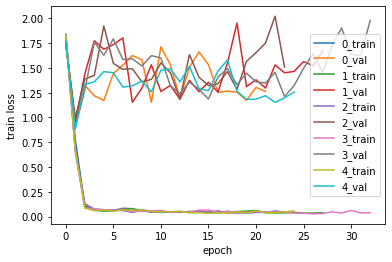

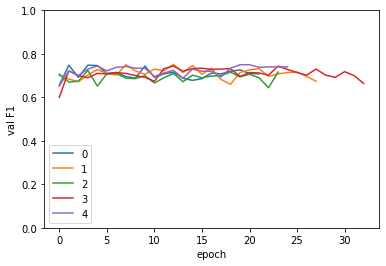

No handles with labels found to put in legend.


average test F1: 0.78


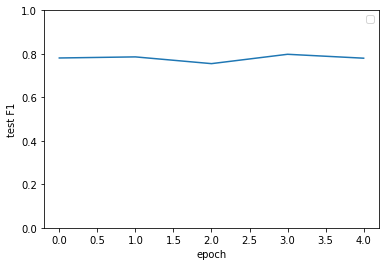

In [169]:
for i in all_res:
    df_temp = pd.DataFrame(all_res[i]['train'])
    plt.plot(df_temp['epoch'], df_temp['train_loss'], label=str(i) + '_train')
    plt.plot(df_temp['epoch'], df_temp['val_losses'], label=str(i) + '_val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show()
plt.clf()

for i in all_res:
    df_temp = pd.DataFrame(all_res[i]['train'])
    plt.plot(df_temp['epoch'], df_temp['val_f1'], label=str(i))
plt.legend()
plt.ylim(0,1)
plt.xlabel('epoch')
plt.ylabel('val F1')
plt.show()
plt.clf()

t = []
for i in all_res:
    t.append(np.average(all_res[i]['test']))
plt.plot(range(len(t)), t)
plt.ylim(0,1)
plt.xlabel('epoch')
plt.ylabel('test F1')

print ('average test F1:', np.average(t))